In [0]:
import  numpy  as  np
import  pandas  as pd
import  pickle
from  collections import defaultdict
import re
import sys
import os
from sklearn.datasets import fetch_20newsgroups
from keras.datasets import reuters
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, BatchNormalization, Activation, LSTM
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the dataset

In [4]:
data_train = fetch_20newsgroups(subset='train', shuffle=True)
data_test = fetch_20newsgroups(subset='test', shuffle=True)

In [5]:
set(data_train.target_names)

{'alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'}

In [6]:
nb_classes=len(set(data_train.target_names))
print('No. of unique classes',nb_classes)

No. of unique classes 20


In [0]:
x_train=data_train.data
y_train=data_train.target

In [0]:
x_test=data_test.data
y_test=data_test.target

# Transform the target classes to categorical

In [0]:
y_train=to_categorical(y_train, nb_classes)
y_test=to_categorical(y_test, nb_classes)

In [10]:
y_train.shape

(11314, 20)

In [11]:
len(x_train), len(x_test)

(11314, 7532)

In [12]:
raw_sentences=x_train+x_test
len(raw_sentences)

18846

# Cleaning using nltk

In [0]:
from nltk.corpus import stopwords
def sentence_clean(raw):
    stop = stopwords.words('english')
    sin_mail=re.sub('[\w.$-]+@[\w.$-]+','',raw)
    clean = re.sub("[^a-zA-Z]"," ", sin_mail)
    words = " ".join([word.lower() for word in clean.split() if (word.lower() not in stop) and (len(word)>1)])
    return words

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_clean(raw_sentence))

In [16]:
len(sentences)

18846

In [42]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 106230


In [43]:
MAX_SEQUENCE_LENGTH=0
for i in range(len(sequences)):
    if len(sequences[i])>MAX_SEQUENCE_LENGTH:
        MAX_SEQUENCE_LENGTH=len(sequences[i])
MAX_SEQUENCE_LENGTH

12653

In [0]:
data = pad_sequences(sequences, maxlen=1000)

In [45]:
data.shape

(18846, 1000)

In [46]:
data_train=data[:len(x_train)]
data_test=data[len(x_train):]
data_train.shape, data_test.shape

((11314, 1000), (7532, 1000))

In [0]:
#from google.colab import files

#uploaded = files.upload()

In [48]:
! pip install pydrive
# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1UBSqb68ek8CdALsfL9Ljzbb2iv-P9_qF'
downloaded = drive.CreateFile({'id': file_id})
# allows you to temporarily load your file in the notebook VM

# assume the file is called file.csv and it's located at the root of your drive
downloaded.GetContentFile('glove.6B.100d.txt')


In [49]:

embeddings_index= {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    codes = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = codes
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [0]:
vocab_len=len(word_index)+1
emb_dim=embeddings_index.get('one').shape[0]
emb_matrix=np.random.random((vocab_len,emb_dim))
for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        emb_matrix[index,:] = embedding_vector
embedding_layer = Embedding(vocab_len, emb_dim, weights=[emb_matrix], input_length=1000,trainable=True)

In [51]:
emb_matrix.shape

(106231, 100)

In [52]:
'''sequence_input = Input(shape=(1000,), dtype='int32')
embeddings = embedding_layer(sequence_input)
x = Conv1D(128, 3)(embeddings)
x = BatchNormalization(axis=2)(x)
x = Activation('relu')(x)
x = MaxPooling1D(3)(x)

x = Conv1D(256, 3)(x)
x = BatchNormalization(axis=2)(x)
x = Activation('relu')(x)
x = MaxPooling1D(3)(x)

x = Conv1D(512, 3)(x)
x = BatchNormalization(axis=2)(x)
x = Activation('relu')(x)
x = MaxPooling1D(3)(x)  

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(nb_classes, activation='softmax')(x)

model = Model(sequence_input, x)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('textClassification_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)'''

'sequence_input = Input(shape=(1000,), dtype=\'int32\')\nembeddings = embedding_layer(sequence_input)\nx = Conv1D(128, 3)(embeddings)\nx = BatchNormalization(axis=2)(x)\nx = Activation(\'relu\')(x)\nx = MaxPooling1D(3)(x)\n\nx = Conv1D(256, 3)(x)\nx = BatchNormalization(axis=2)(x)\nx = Activation(\'relu\')(x)\nx = MaxPooling1D(3)(x)\n\nx = Conv1D(512, 3)(x)\nx = BatchNormalization(axis=2)(x)\nx = Activation(\'relu\')(x)\nx = MaxPooling1D(3)(x)  \n\nx = Flatten()(x)\nx = Dense(128, activation=\'relu\')(x)\nx = Dropout(0.5)(x)\nx = Dense(nb_classes, activation=\'softmax\')(x)\n\nmodel = Model(sequence_input, x)\nmodel.compile(loss=\'categorical_crossentropy\',\n              optimizer=\'rmsprop\',\n              metrics=[\'acc\'])\n\nprint("Simplified convolutional neural network")\nmodel.summary()\ncp=ModelCheckpoint(\'textClassification_cnn.hdf5\',monitor=\'val_acc\',verbose=1,save_best_only=True)'

In [84]:
sequence_input = Input(shape=(1000,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5)(embedded_sequences)
#x = BatchNormalization(axis=2)(x)
x = Activation('relu')(x)
#x = Dropout(0.5)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5)(x)
#x = BatchNormalization(axis=2)(x)
x = Activation('relu')(x)
#x = Dropout(0.5)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(20, activation='softmax')(x)
adam = Adam(lr=0.00001)
model = Model(sequence_input, x)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('textClassification_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         10623100  
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 996, 128)          64128     
_________________________________________________________________
activation_31 (Activation)   (None, 996, 128)          0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 199, 128)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 195, 128)          82048     
_________________________________________________________________
activation_32 (Activation)   (None, 

In [85]:
history=model.fit(data_train, y_train, validation_data=(data_test, y_test),epochs=20, batch_size=16,callbacks=[cp])

Train on 11314 samples, validate on 7532 samples
Epoch 1/20
11314/11314 [==============================] - 26s 2ms/step - loss: 2.9960 - acc: 0.0610 - val_loss: 2.9282 - val_acc: 0.1118

Epoch 00001: val_acc improved from -inf to 0.11179, saving model to textClassification_cnn.hdf5
Epoch 2/20
11314/11314 [==============================] - 23s 2ms/step - loss: 2.8705 - acc: 0.1346 - val_loss: 2.8162 - val_acc: 0.2197

Epoch 00002: val_acc improved from 0.11179 to 0.21973, saving model to textClassification_cnn.hdf5
Epoch 3/20
11314/11314 [==============================] - 23s 2ms/step - loss: 2.6993 - acc: 0.2226 - val_loss: 2.6213 - val_acc: 0.3205

Epoch 00003: val_acc improved from 0.21973 to 0.32050, saving model to textClassification_cnn.hdf5
Epoch 4/20
11314/11314 [==============================] - 23s 2ms/step - loss: 2.4425 - acc: 0.3139 - val_loss: 2.3472 - val_acc: 0.4334

Epoch 00004: val_acc improved from 0.32050 to 0.43335, saving model to textClassification_cnn.hdf5
Epoch 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


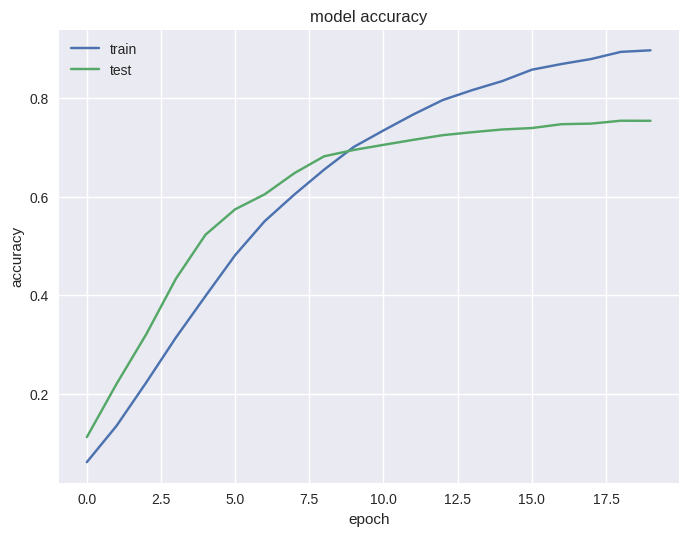

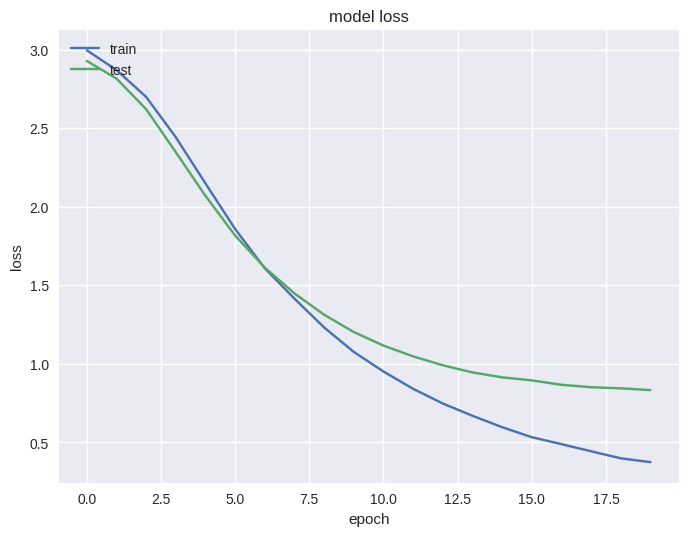

In [86]:
# list all data in history
print(history.history.keys())
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join('model accuracy accuracy.png'))
plt.show()
# summarize history for loss
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join('model loss loss.png'))
plt.show()

# Model LSTM

In [89]:
sequence_input = Input(shape=(1000,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
y = LSTM(128, return_sequences=True)(embedded_sequences)
y = Dropout(0.5)(y)

#y = LSTM(128, return_sequences=True)(y)
#y = Dropout(0.5)(y)

y = LSTM(128, return_sequences=False)(y)
y = Dropout(0.3)(y)

y = Dense(nb_classes, activation='softmax')(y)

model_rnn = Model(sequence_input, y)
#adam = Adam(lr=0.0001)
model_rnn.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified recurrent neural network")
model_rnn.summary()
cp_rnn=ModelCheckpoint('textClassification_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Simplified recurrent neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         10623100  
_________________________________________________________________
lstm_5 (LSTM)                (None, 1000, 128)         117248    
_________________________________________________________________
dropout_12 (Dropout)         (None, 1000, 128)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 20) 

In [0]:
history_rnn=model_rnn.fit(data_train, y_train, validation_data=(data_test, y_test),epochs=8, batch_size=512,callbacks=[cp_rnn])

Train on 11314 samples, validate on 7532 samples
Epoch 1/8
 2560/11314 [=====>........................] - ETA: 2:06 - loss: 2.8305 - acc: 0.1613

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


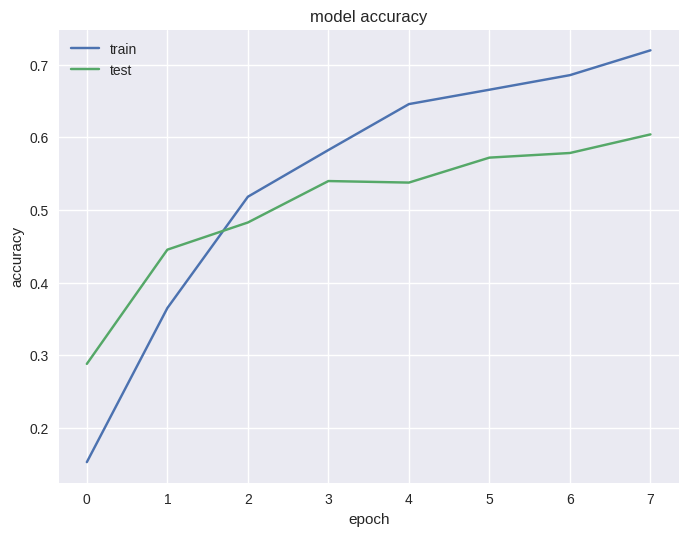

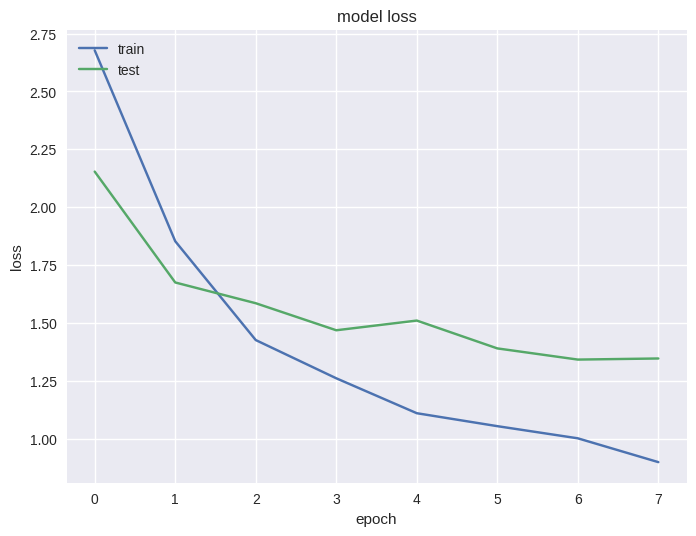

In [38]:
# list all data in history
print(history_rnn.history.keys())
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(history_rnn.history['acc'])
plt.plot(history_rnn.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join('model accuracy accuracy2.png'))
plt.show()
# summarize history for loss
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join('model loss loss2.png'))
plt.show()